<a href="https://colab.research.google.com/github/keran-w/3d-deep-learning/blob/main/pointnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Pointnet Example

**Reference:** https://github.com/nikitakaraevv/pointnet

### Load Dataset from Kaggle

In [2]:
# use github private repo in colab
from google.colab import drive
from IPython.display import clear_output
drive.mount('/content/drive', force_remount=True)
clear_output()

Mounted at /content/drive


In [3]:
import os
DOWNLOAD = False

if DOWNLOAD:
  # add kaggle token from drive
  if not os.path.isfile('~/.kaggle/kaggle.json'):
    os.system('mkdir ~/.kaggle')
    os.system('cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json')

  # download and unzip kaggle dataset
  !kaggle datasets download -d balraj98/modelnet40-princeton-3d-object-dataset
  !unzip modelnet40-princeton-3d-object-dataset.zip -d .
  clear_output()

## EDA

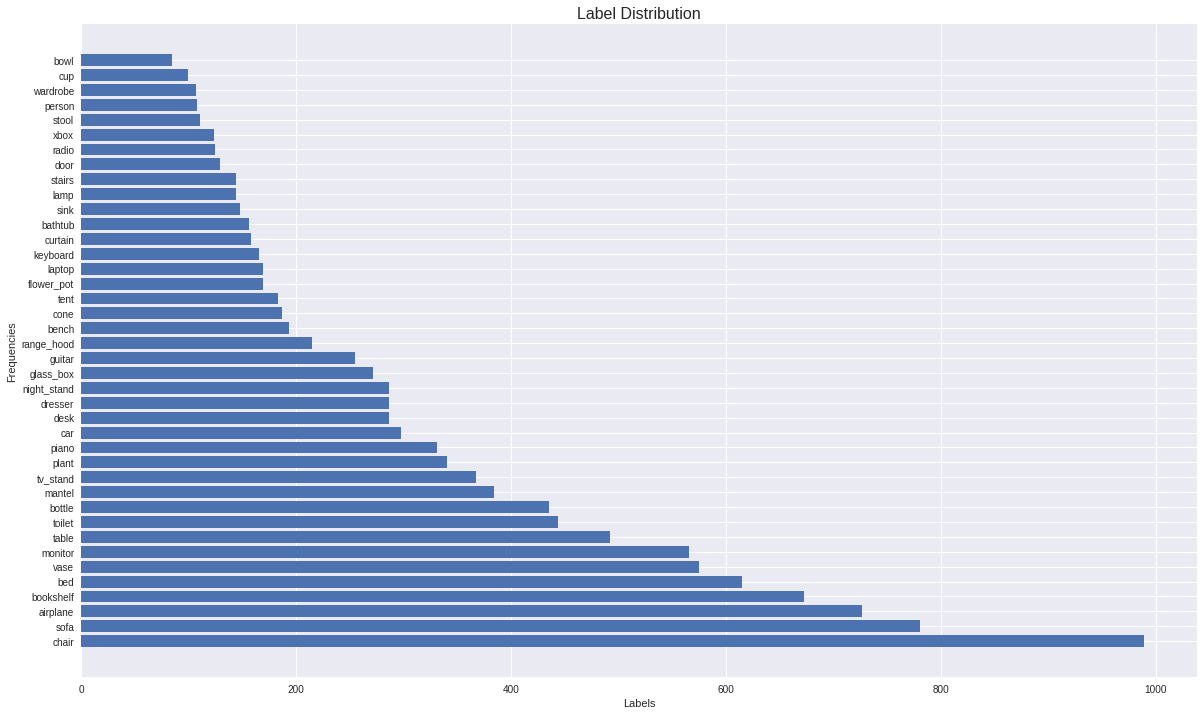

In [31]:
import seaborn as sns
from matplotlib import pyplot as plt
plt.style.use('seaborn-v0_8')


# get all labels and label distribution
dataset_dir = "./ModelNet40"
labels = sorted(os.listdir(dataset_dir))

label_distribution = {
    label:len(
        os.listdir(f'{dataset_dir}/{label}/train') +
        os.listdir(f'{dataset_dir}/{label}/test')
        ) for label in labels
}
label_distribution = dict(sorted(label_distribution.items(), key=lambda item: item[1], reverse=True))


fig, ax = plt.subplots(figsize=(20, 12))
ax.barh(list(label_distribution.keys()),
         list(label_distribution.values())
)
ax.set_xlabel('Labels')
ax.set_ylabel('Frequencies')
ax.set_title('Label Distribution', fontsize=16)
plt.show()

In [46]:
# read in data
def read_off(file):
    if 'OFF' != file.readline().strip():
        raise('Not a valid OFF header')
    n_verts, n_faces, __ = tuple([int(s) for s in file.readline().strip().split(' ')])
    verts = [[float(s) for s in file.readline().strip().split(' ')] for i_vert in range(n_verts)]
    faces = [[int(s) for s in file.readline().strip().split(' ')][1:] for i_face in range(n_faces)]
    return verts, faces

# read a sample model
sample_label = 'bed'
with open(f'{dataset_dir}/{sample_label}/train/{sample_label}_0001.off', 'r') as f:
  verts, faces = read_off(f)

In [47]:
import numpy as np
# visualize a model
import plotly.graph_objects as go
def visualize_rotate(data):
    x_eye, y_eye, z_eye = 1.25, 1.25, 0.8
    frames=[]

    def rotate_z(x, y, z, theta):
        w = x+1j*y
        return np.real(np.exp(1j*theta)*w), np.imag(np.exp(1j*theta)*w), z

    for t in np.arange(0, 10.26, 0.1):
        xe, ye, ze = rotate_z(x_eye, y_eye, z_eye, -t)
        frames.append(dict(layout=dict(scene=dict(camera=dict(eye=dict(x=xe, y=ye, z=ze))))))
    fig = go.Figure(data=data,
                    layout=go.Layout(
                        updatemenus=[dict(type='buttons',
                                    showactive=False,
                                    y=1,
                                    x=0.8,
                                    xanchor='left',
                                    yanchor='bottom',
                                    pad=dict(t=45, r=10),
                                    buttons=[dict(label='Play',
                                                    method='animate',
                                                    args=[None, dict(frame=dict(duration=50, redraw=True),
                                                                    transition=dict(duration=0),
                                                                    fromcurrent=True,
                                                                    mode='immediate'
                                                                    )]
                                                    )
                                            ]
                                    )
                                ]
                    ),
                    frames=frames
            )

    return fig

i,j,k = np.array(faces).T
x,y,z = np.array(verts).T
visualize_rotate([go.Mesh3d(x=x, y=y, z=z, color='lightpink', opacity=0.50, i=i,j=j,k=k)]).show()